In [1]:
from stpy.kernels import KernelFunction
from stpy.continuous_processes.nystrom_fea import NystromFeatures
from stpy.helpers.helper import interval_torch
import torch
from torch.nn import Sequential, Linear
import torch.optim as optim
import numpy as np
import tqdm
from mtevi import EvidenceRegularizer, EvidentialnetMarginalLikelihood

from robust_likelihoods import ShallowModel, AminiModel, StudentTModel
from robust_likelihoods import generate_data, generate_outliers
from robust_likelihoods import huber_loss, student_t_loss, amini_loss

In [2]:
np.random.seed(10)
torch.manual_seed(10)

num_points = 20

a = -1
b = 1
outlier_frac = 0.1

d = 1

# parabola nd
def F(X):
    fac = 1/X.shape[-1]
    squares = np.sin(torch.sum(X**2, dim=-1, keepdim=False)*7)*4
    squares = np.expand_dims(squares, 1)
    return fac * squares
eps = lambda X: 0

X, Y = generate_data(F, d, eps, a, b, num_points)
X_outliers, Y_outliers = generate_outliers(F, eps, a, b, int(outlier_frac*num_points))

# X_t = np.concatenate([X, X_outliers], axis=0)
# Y_t = np.concatenate([Y, Y_outliers], axis=0)

X_t = X
Y_t = Y

X_t = torch.tensor(X_t, dtype=torch.float64)
Y_t = torch.tensor(Y_t, dtype=torch.float64)

# X_test, Y_test = generate_data(F, a=-6, b=13, num_points=500)
X_test, Y_test = torch.tensor(X, dtype=torch.float64), torch.tensor(Y, dtype=torch.float64)

C:\Users\queim\AppData\Local\Temp\ipykernel_19720\969185310.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t = torch.tensor(X_t, dtype=torch.float64)
C:\Users\queim\AppData\Local\Temp\ipykernel_19720\969185310.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, Y_test = torch.tensor(X, dtype=torch.float64), torch.tensor(Y, dtype=torch.float64)


In [3]:
# kernel = KernelFunction(kernel_name="squared_exponential", gamma=0.1, kappa=1.,d = d)
model = StudentTModel(input_dim=X_t.shape[1], emb_dim=X_t.shape[0], output_dim=Y_t.shape[1], gamma=0.1, kappa=1., d=d)

In [4]:
from torchmin import Minimizer

optimizer = Minimizer(model.parameters(), method="l-bfgs")
# >>> def closure():
#         >>>    optimizer.zero_grad()
#         >>>    output = model(input)
#         >>>    loss = loss_fn(output, target)
#         >>>    # loss.backward() <-- skip this step!
#         >>>    return loss

def fit_model(model, X, Y, optimizer, loss_fn, num_epochs=100):
    def closure():
        optimizer.zero_grad()
        loss = loss_fn(X, Y, model)
        # loss.backward()
        return loss

    pbar = tqdm.tqdm(range(num_epochs))
    for i in pbar:
        loss = optimizer.step(closure)
        pbar.set_postfix({"loss": loss.item()})
        # print(loss.item())
        
    loss = loss_fn(X, Y, model)
        
    return model, loss

fit_model(model, X_t, Y_t, optimizer, student_t_loss, num_epochs=100)

100%|██████████| 100/100 [00:03<00:00, 25.66it/s, loss=-8.31]


(StudentTModel(
   (dense): Linear(in_features=20, out_features=3, bias=False)
 ),
 tensor(-8.3075, dtype=torch.float64, grad_fn=<MeanBackward0>))

In [ ]:
#hyper parameter optimization

from torchmin import Minimizer

optimizer = Minimizer(model.parameters())
# >>> def closure():
#         >>>    optimizer.zero_grad()
#         >>>    output = model(input)
#         >>>    loss = loss_fn(output, target)
#         >>>    # loss.backward() <-- skip this step!
#         >>>    return loss

def fit_model(model, X, Y, optimizer, loss_fn, num_epochs=100):
    def closure():
        optimizer.zero_grad()
        loss = loss_fn(X, Y, model)
        # loss.backward()
        return loss

    pbar = tqdm.tqdm(range(num_epochs))
    for i in pbar:
        loss = optimizer.step(closure)
        pbar.set_postfix({"loss": loss.item()})
        
    loss = loss_fn(X, Y, model)
        
    return model, loss

fit_model(model, X_t, Y_t, optimizer, student_t_loss, num_epochs=100)

def fit_hyperparameters_mll():
    
    loggamma = torch.nn.Parameter(torch.tensor(0.5, dtype=torch.float64))
    optimizer = torch.optim.Adam([loggamma], lr=0.1)
    
    def mll(X, Y, model):
        gamma = torch.exp(loggamma)
        kernel = KernelFunction(kernel_name="squared_exponential", gamma=gamma, kappa=1.1,d = d)
        model = StudentTModel(input_dim=X_t.shape[1], emb_dim=X_t.shape[0], output_dim=Y_t.shape[1], kernel=kernel)
        model, loss = fit_model(model, X, Y, optimizer, student_t_loss, num_epochs=100)
        return loss
    
    def closure():
        optimizer.zero_grad()
        loss = mll(X_t, Y_t, model)
        return loss
    
    pbar = tqdm.tqdm(range(100))
    for i in pbar:
        loss = closure()
        loss.backward()
        optimizer.step()
        # loss = optimizer.step(closure)
        print(torch.exp(loggamma))
        
        pbar.set_postfix({"loss": loss.item()})
        
    return model

model = fit_hyperparameters_mll()
    

In [6]:
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# #set_postfix loss print
# pbar = tqdm.tqdm(range(1000))
# for i in pbar:
#     optimizer.zero_grad()
#     loss = student_t_loss(X_t, Y_t, model)
#     loss.backward()
#     optimizer.step()
#     pbar.set_postfix(loss=f'{loss.item():.4f}')


In [7]:
import botorch
from botorch.models import SingleTaskGP, FixedNoiseGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import gpytorch

# Convert data to torch tensors
X_t_tensor = torch.tensor(X_t, dtype=torch.double)
Y_t_tensor = torch.tensor(Y_t, dtype=torch.double)

#gpytorch fixed kernel parameters
mean_module = gpytorch.means.ConstantMean()
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

# set values for the covariance function
covar_module.base_kernel.lengthscale = 0.5
covar_module.outputscale = 1.0

bo_model = FixedNoiseGP(X_t_tensor, Y_t_tensor, torch.ones_like(Y_t_tensor)*0.1, mean_module=mean_module, covar_module=covar_module)

# Fit the model
mll = ExactMarginalLogLikelihood(bo_model.likelihood, bo_model)
# botorch.fit_gpytorch_mll(mll)

# Test data
# test_x = torch.tensor(np.linspace(-3, 10, 1000).reshape(-1, 1), dtype=torch.double)
test_x = interval_torch(100, d)

# Make predictions
bo_model.eval()
with torch.no_grad():
    posterior = bo_model.posterior(test_x)
    pred_y = posterior.mean.squeeze().numpy()
    std_y = posterior.variance.sqrt().squeeze().numpy()

bo_model.state_dict()

C:\Users\queim\AppData\Local\Temp\ipykernel_19720\668897464.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t_tensor = torch.tensor(X_t, dtype=torch.double)
C:\Users\queim\AppData\Local\Temp\ipykernel_19720\668897464.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_t_tensor = torch.tensor(Y_t, dtype=torch.double)
c:\Users\queim\micromambaenv\envs\stpy39\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\queim\micromambaenv\envs\stpy39\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input d

OrderedDict([('mean_module.raw_constant', tensor(0., dtype=torch.float64)),
             ('covar_module.raw_outputscale',
              tensor(0.5413, dtype=torch.float64)),
             ('covar_module.base_kernel.raw_lengthscale',
              tensor([[-0.4328]], dtype=torch.float64)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0., dtype=torch.float64)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf, dtype=torch.float64)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0., dtype=torch.float64)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf, dtype=torch.float64))])

In [8]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPytorchStudTModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(train_x.size(0)).double()
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        ).double()
        super(GPytorchStudTModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean().double()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()).double()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


X_t_tensor = torch.tensor(X_t, dtype=torch.double)
Y_t_tensor = torch.tensor(Y_t, dtype=torch.double)
# Initialize model and likelihood
model_gpyt = GPytorchStudTModel(X_t_tensor)
likelihood = gpytorch.likelihoods.StudentTLikelihood()
training_iterations = 500


# Find optimal model hyperparameters
model_gpyt.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(list(model_gpyt.parameters()) + list(likelihood.parameters()), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
# mll = gpytorch.mlls.VariationalELBO(likelihood, model_gpyt, Y_t_tensor.numel())
# gpytorch.mlls.PredictiveLogLikelihood
mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model_gpyt, num_data=Y_t_tensor.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model_gpyt(X_t_tensor)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_t_tensor.squeeze())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

# Use the Minimizer from torchmin
# optimizer = Minimizer(model_gpyt.parameters())
# mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model_gpyt, num_data=Y_t_tensor.numel())

# def closure():
#     optimizer.zero_grad()
#     output = model_gpyt(X_t_tensor)
#     loss = -mll(output, Y_t_tensor.squeeze())
#     return loss

# # Training loop with tqdm for progress display
# num_epochs = 1000
# pbar = tqdm.tqdm(range(num_epochs))
# for i in pbar:
#     loss = optimizer.step(closure)
#     pbar.set_postfix({"loss": loss.item()})

# # Final loss evaluation
# final_loss = closure()
# print("Final Loss: %.3f" % final_loss.item())


C:\Users\queim\AppData\Local\Temp\ipykernel_19720\1995513729.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t_tensor = torch.tensor(X_t, dtype=torch.double)
C:\Users\queim\AppData\Local\Temp\ipykernel_19720\1995513729.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_t_tensor = torch.tensor(Y_t, dtype=torch.double)


Iter 1/500 - Loss: 3.136
Iter 2/500 - Loss: 2.696
Iter 3/500 - Loss: 2.549
Iter 4/500 - Loss: 2.536
Iter 5/500 - Loss: 2.532
Iter 6/500 - Loss: 2.505
Iter 7/500 - Loss: 2.468
Iter 8/500 - Loss: 2.432
Iter 9/500 - Loss: 2.402
Iter 10/500 - Loss: 2.378
Iter 11/500 - Loss: 2.360
Iter 12/500 - Loss: 2.346
Iter 13/500 - Loss: 2.335
Iter 14/500 - Loss: 2.326
Iter 15/500 - Loss: 2.320
Iter 16/500 - Loss: 2.316
Iter 17/500 - Loss: 2.313
Iter 18/500 - Loss: 2.309
Iter 19/500 - Loss: 2.304
Iter 20/500 - Loss: 2.299
Iter 21/500 - Loss: 2.294
Iter 22/500 - Loss: 2.291
Iter 23/500 - Loss: 2.286
Iter 24/500 - Loss: 2.279
Iter 25/500 - Loss: 2.269
Iter 26/500 - Loss: 2.261
Iter 27/500 - Loss: 2.256
Iter 28/500 - Loss: 2.251
Iter 29/500 - Loss: 2.246
Iter 30/500 - Loss: 2.241
Iter 31/500 - Loss: 2.236
Iter 32/500 - Loss: 2.231
Iter 33/500 - Loss: 2.228
Iter 34/500 - Loss: 2.223
Iter 35/500 - Loss: 2.218
Iter 36/500 - Loss: 2.211
Iter 37/500 - Loss: 2.204
Iter 38/500 - Loss: 2.198
Iter 39/500 - Loss: 2

In [9]:
X_fine = interval_torch(100, d)

In [10]:
# X_t.shape
# # torch.Size([100, 2])

# Y_t.shape
# # torch.Size([100, 1])

# # plot countourf

# import matplotlib.pyplot as plt
# from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # ax.plot_surface(X_t[:, 0].reshape(10, 10), X_t[:, 1].reshape(10, 10), Y_t.reshape(10, 10), cmap=cm.coolwarm)
# # ax.plot_surface(X_t[:, 0].reshape(10, 10), X_t[:, 1].reshape(10, 10), model(X_t).detach().numpy()[:,0].reshape(10, 10), cmap=cm.coolwarm)
# ax.plot_surface(X_fine[:, 0].reshape(100, 100), X_fine[:, 1].reshape(100, 100), model(X_fine).detach().numpy()[:,0].reshape(100, 100), cmap=cm.coolwarm)
# ax.plot_surface(X_fine[:, 0].reshape(100, 100), X_fine[:, 1].reshape(100, 100), model_gpyt(X_fine).mean.detach().numpy().reshape(100, 100), cmap=cm.coolwarm)
# #botorch
# # ax.plot_surface(X_fine[:, 0].reshape(100, 100), X_fine[:, 1].reshape(100, 100), pred_y.reshape(100, 100), cmap=cm.coolwarm)

# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# plt.show()

TypeError: sum() received an invalid combination of arguments - got (numpy.ndarray, dim=int, keepdim=bool), but expected one of:
 * (Tensor input, *, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: dim, keepdim
 * (Tensor input, tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)


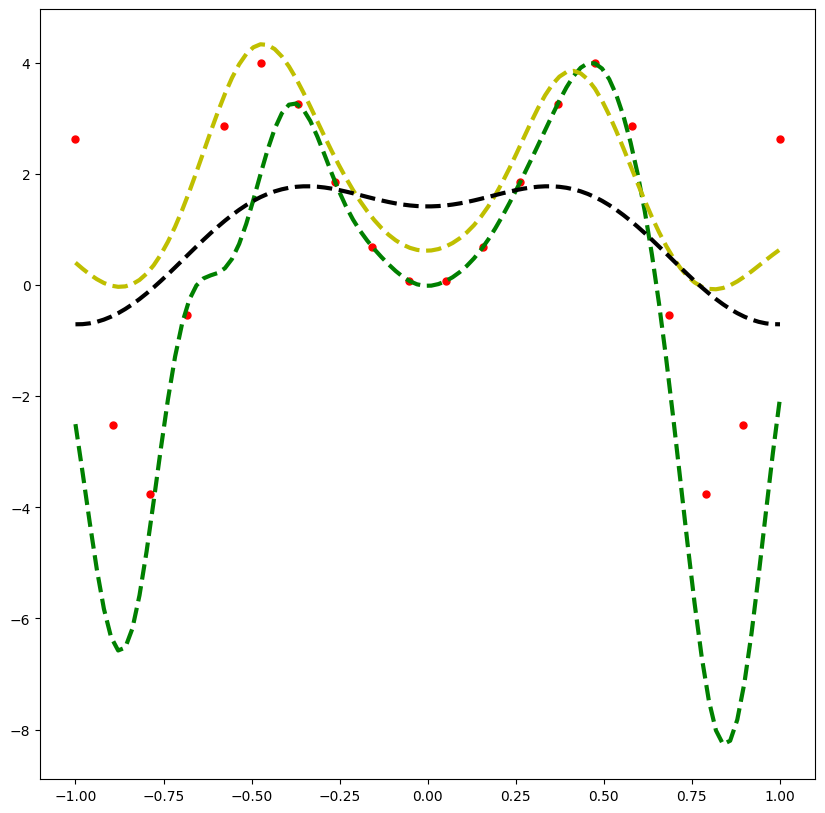

In [11]:
import matplotlib.pyplot as plt

x_fine = X_fine
plt.figure(figsize=(10,10))
# X_t.shape
# torch.Size([100, 2])
plt.plot(X_t, Y_t, 'r.', markersize=10)
# plt.plot(X_outliers, Y_outliers, 'rx')
plt.plot(x_fine, model(x_fine).detach().numpy()[:,0],'g--', lw=3, label='GP Model')
plt.plot(x_fine, model_gpyt(x_fine).mean.detach().numpy(),'y--', lw=3, label='GPytorchStudT Model')
plt.plot(x_fine, pred_y, 'k--', lw=3, label='BoTorch Model')
plt.plot(x_fine, F(x_fine.numpy()),'b-', lw=3, label='True Function', zorder=0)
plt.legend()
ax = plt.gca()
ax.set_ylim(-5, 10)

In [ ]:
# model parameters
# list(model.parameters())

In [ ]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut, RandomizedSearchCV
from skorch import NeuralNetRegressor
from skorch.net import unpack_data

#torch loss
from torch.nn import MSELoss
from robust_likelihoods import StudentTLoss

class MyRegressor(NeuralNetRegressor):
    def score(self, X, y):
        return -self.criterion_(self.predict(X), y)

sk_model = MyRegressor(
    module=StudentTModel,
    module__input_dim=X_t.shape[1],
    module__emb_dim=X_t.shape[0]//10,
    module__output_dim=1,
    module__gamma=0.1,
    module__kappa=1.1,
    module__d=d,
    optimizer=optim.Adam,
    max_epochs=100,
    criterion=StudentTLoss(),
    verbose=3,
    batch_size=-1,
)

sk_model.set_params(train_split=False, verbose=2)
params = {
    'module__gamma': list(np.linspace(0.1, 6.0, 10)),
    'module__kappa': list(np.linspace(0.1, 6.0, 10)),
}
loo = LeaveOneOut()
gs = GridSearchCV(sk_model, params, refit=False, cv=10, verbose=10, n_jobs=-1)
# gs = RandomizedSearchCV(sk_model, params, n_iter=10, refit=False, cv=10, verbose=10, n_jobs=-1)


gs.fit(X_t_tensor, Y_t_tensor)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best score: -2.445, best params: {'module__gamma': 3.3777777777777778, 'module__kappa': 5.344444444444444}


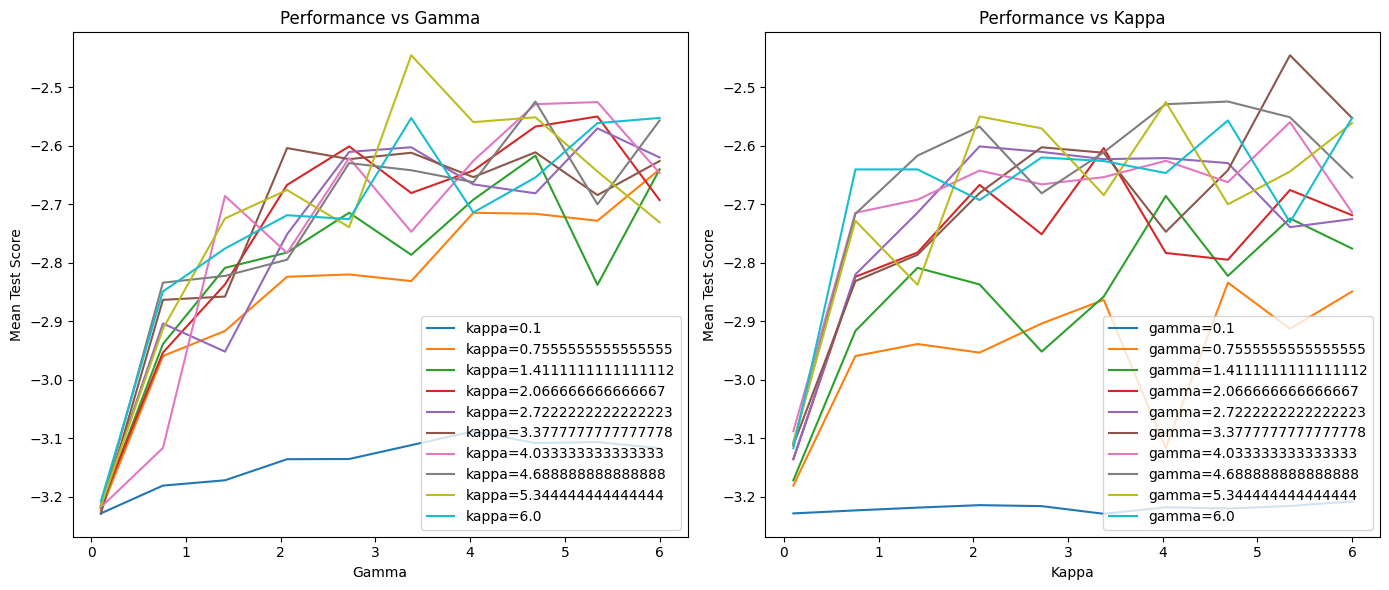

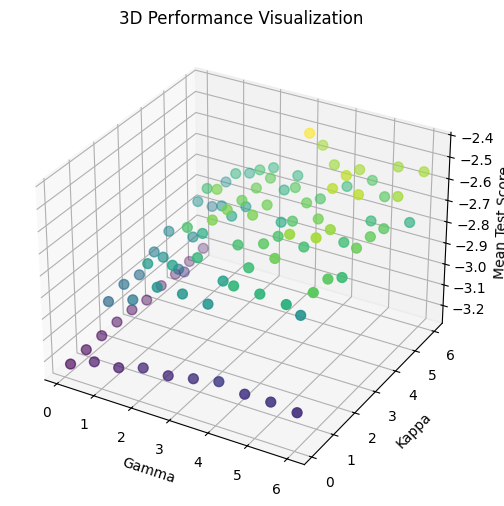

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract grid search results into a DataFrame
cv_results = pd.DataFrame(gs.cv_results_)

# Create a pivot table to better visualize the grid search results
pivot = cv_results.pivot_table(
    index="param_module__gamma", 
    columns="param_module__kappa", 
    values="mean_test_score"
)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Line plot for `module__gamma` vs `mean_test_score`
for kappa in params['module__kappa']:
    subset = cv_results[cv_results['param_module__kappa'] == kappa]
    ax[0].plot(subset['param_module__gamma'], subset['mean_test_score'], label=f'kappa={kappa}')
ax[0].set_title('Performance vs Gamma')
ax[0].set_xlabel('Gamma')
ax[0].set_ylabel('Mean Test Score')
ax[0].legend()

# 2. Line plot for `module__kappa` vs `mean_test_score`
for gamma in params['module__gamma']:
    subset = cv_results[cv_results['param_module__gamma'] == gamma]
    ax[1].plot(subset['param_module__kappa'], subset['mean_test_score'], label=f'gamma={gamma}')
ax[1].set_title('Performance vs Kappa')
ax[1].set_xlabel('Kappa')
ax[1].set_ylabel('Mean Test Score')
ax[1].legend()

plt.tight_layout()
plt.show()

# Optional: 3D plot to see the combined effect
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    cv_results['param_module__gamma'],
    cv_results['param_module__kappa'],
    cv_results['mean_test_score'],
    c=cv_results['mean_test_score'], cmap='viridis', s=50
)
ax.set_title('3D Performance Visualization')
ax.set_xlabel('Gamma')
ax.set_ylabel('Kappa')
ax.set_zlabel('Mean Test Score')
plt.show()
